# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 09.11.2023

Мягкий дедлайн: 22.11.2023

Жесткий дедлайн: 26.11.2023

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**: 6.0

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного жёсткого дедлайна нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [3]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: Потому что здесь используется метод *predict_proba*, который выдает вероятности отнесения к классам, а затем эти вероятности используются в predict* для отнесения к $1$ и $0$.

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [4]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000


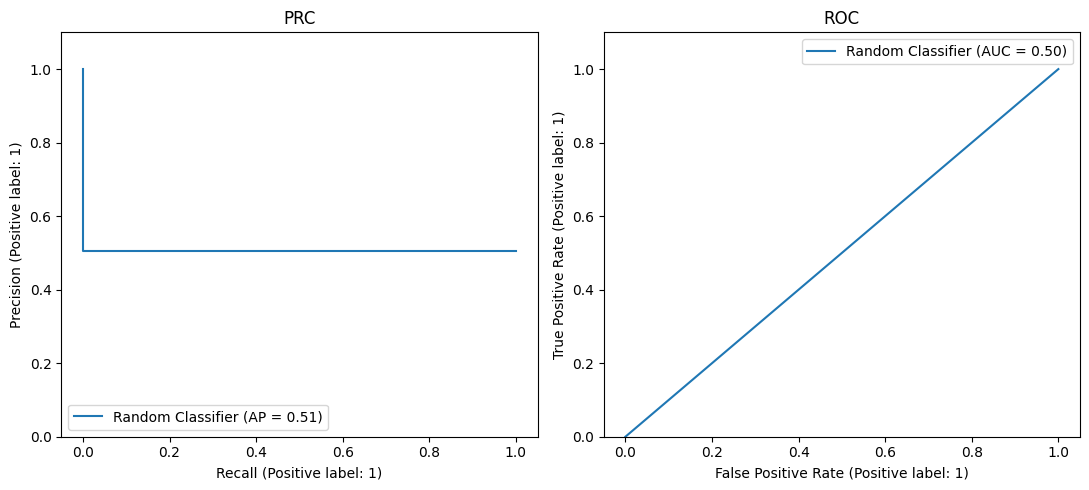

In [5]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
  if ax is None:
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))

  print(classifier_name, 'metrics')
  PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
  precision, recall, _ = precision_recall_curve(y_true, y_pred)
  print('AUC-PR: %.5f' % auc(recall, precision))
  ax[0].set_title("PRC")
  ax[0].set_ylim(0, 1.1)

  RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
  print('AUC-ROC: %.5f' % roc_auc_score(y_true, y_pred))
  ax[1].set_title("ROC")
  ax[1].set_ylim(0, 1.1)

  plt.tight_layout()
  plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [6]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])
precision, recall, _ = precision_recall_curve(y_test, y_random)
  # добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_random),
      0
]

  # по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`).

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [7]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

# Создаем массив для поиска оптимального значения C
C_values = [0.001, 0.01, 0.1, 1, 10]

# Инициализируем DataFrame для хранения результатов
svm_metrics = pd.DataFrame(columns=['C', 'AUC_PR', 'AUC_ROC'])

# Обучаем модель SVM с калибровкой вероятностей для каждого значения C
for C in C_values:
    svm = LinearSVC(C=C, random_state=42, max_iter=10000)
    calibrated_svm = CalibratedClassifierCV(svm)
    calibrated_svm.fit(X_train, y_train)
    # Получаем вероятности для класса 1
    y_pred_svm = calibrated_svm.predict_proba(X_test)[:, 1]

    # Вычисляем метрики
    precision, recall, _ = precision_recall_curve(y_test, y_pred_svm)
    auc_pr = auc(recall, precision)
    auc_roc = roc_auc_score(y_test, y_pred_svm)

    # Добавляем результаты в DataFrame
    svm_metrics = svm_metrics.append({'C': C, 'AUC_PR': auc_pr, 'AUC_ROC': auc_roc}, ignore_index=True)

# Выводим результаты
svm_metrics.sort_values(by="AUC_PR", ascending=False)

<ipython-input-7-950eb3198fdc>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  svm_metrics = svm_metrics.append({'C': C, 'AUC_PR': auc_pr, 'AUC_ROC': auc_roc}, ignore_index=True)
<ipython-input-7-950eb3198fdc>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  svm_metrics = svm_metrics.append({'C': C, 'AUC_PR': auc_pr, 'AUC_ROC': auc_roc}, ignore_index=True)
<ipython-input-7-950eb3198fdc>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  svm_metrics = svm_metrics.append({'C': C, 'AUC_PR': auc_pr, 'AUC_ROC': auc_roc}, ignore_index=True)
<ipython-input-7-950eb3198fdc>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  svm_metrics = svm_me

,C,AUC_PR,AUC_ROC
3,1.000,0.829652,0.847648
2,0.100,0.829649,0.847644
4,10.000,0.829572,0.847631
1,0.010,0.829560,0.847618
0,0.001,0.829198,0.847370


  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

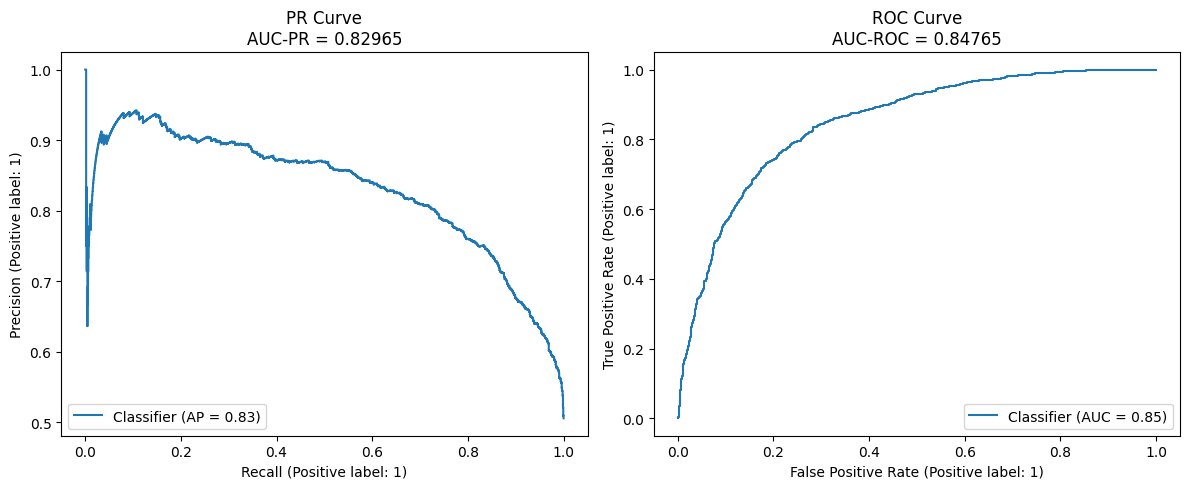

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.500000,0.0
Linear Kernel SVM,0.829652,0.847648,1.0


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import auc, precision_recall_curve, roc_auc_score, PrecisionRecallDisplay, RocCurveDisplay

# Фиксируем random_state для воспроизводимости результатов
X, y = make_classification(n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Фиксируем лучшую C из предыдущего эксперимента
best_C = 1.0
svm_best = LinearSVC(C=best_C, random_state=42, max_iter=10000)
calibrated_svm_best = CalibratedClassifierCV(svm_best)
calibrated_svm_best.fit(X_train, y_train)
y_pred_svm_linear = calibrated_svm_best.predict_proba(X_test)[:, 1]

# Считаем метрики
precision_linear, recall_linear, _ = precision_recall_curve(y_test, y_pred_svm_linear)
auc_pr_linear = auc(recall_linear, precision_linear)
roc_auc_linear = roc_auc_score(y_test, y_pred_svm_linear)

# Построим ROC и PR кривые на тестовой части
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# PR кривая
PrecisionRecallDisplay.from_predictions(y_test, y_pred_svm_linear, ax=ax[0])
ax[0].set_title('PR Curve\nAUC-PR = {:.5f}'.format(auc_pr))

# ROC кривая
RocCurveDisplay.from_predictions(y_test, y_pred_svm_linear, ax=ax[1])
ax[1].set_title('ROC Curve\nAUC-ROC = {:.5f}'.format(roc_auc))

plt.tight_layout()
plt.show()

# Добавление метрик Linear Kernel SVM в DataFrame
df_metrics.loc['Linear Kernel SVM'] = [auc_pr_linear, roc_auc_linear, best_C]

# Выводим DataFrame с результатами
df_metrics

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

**Ответ:** AUC-ROC для случайного классификатора равен 0.5, что ожидаемо, потому что он работает на уровне случайного угадывания. AUC-PR выше для случайного классификатора по сравнению с ожидаемым уровнем, что связано с дисбалансом классов в сгенерированных данных.

Для модели SVM обе метрики значительно выше, чем для случайного классификатора, что указывает на то, что SVM с линейным ядром имеет гораздо более лучшую предсказательную способность.

Таким образом, модель SVM существенно превосходит случайный классификатор по обоим метрикам.

__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



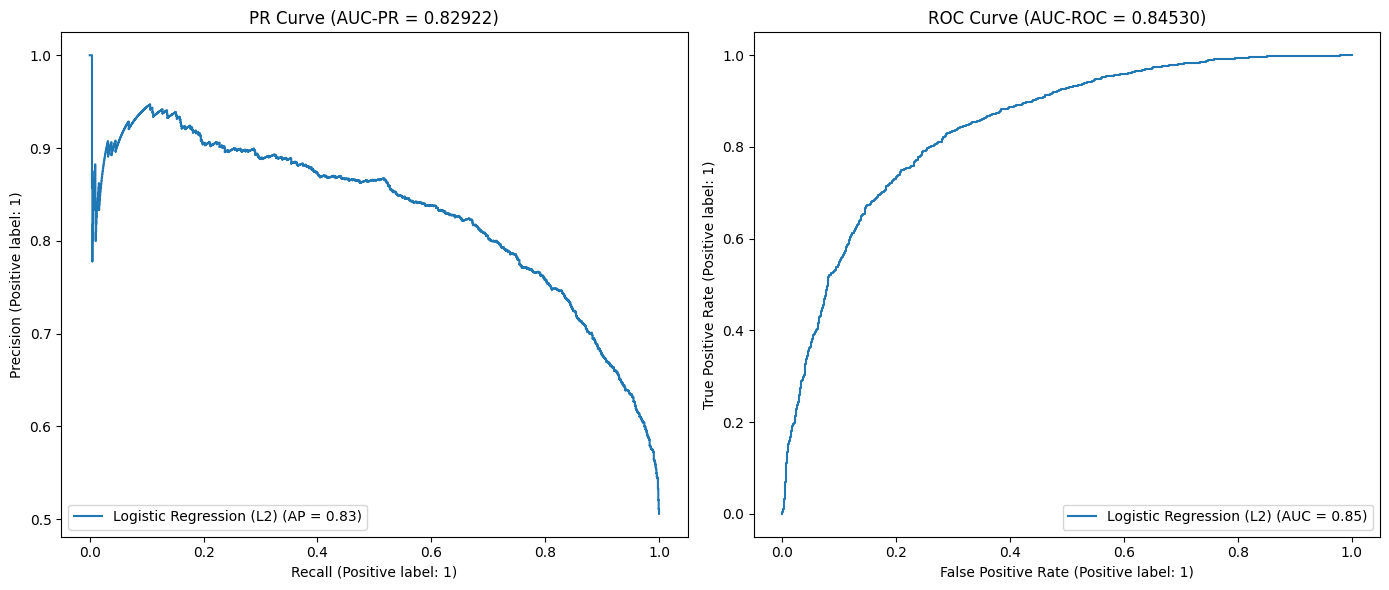

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.500000,0.000
Linear Kernel SVM,0.829652,0.847648,1.000
Logistic Regression (L2),0.829217,0.845298,0.001


In [14]:
# Переопределяем данные и подбираем гиперпараметр C для логистической регрессии
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import auc, precision_recall_curve, roc_auc_score

# Генерируем синтетические данные
X, y = make_classification(n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Список потенциальных гиперпараметров C
C_values = [0.001, 0.01, 0.1, 1, 10]

# Обучаем логистическую регрессию с L2 регуляризацией
log_reg_l2 = LogisticRegressionCV(
    Cs=C_values,
    cv=5,
    scoring="average_precision",
    penalty="l2",
    solver='liblinear',
    max_iter=10000,
    random_state=42
)
log_reg_l2.fit(X_train, y_train)

# Лучшее значение C
best_C_logreg_l2 = log_reg_l2.C_[0]

# Получаем вероятности для тестового набора данных
y_pred_logreg_l2 = log_reg_l2.predict_proba(X_test)[:, 1]

# Расчет метрик AUC-PR и AUC-ROC
precision_logreg_l2, recall_logreg_l2, _ = precision_recall_curve(y_test, y_pred_logreg_l2)
auc_pr_logreg_l2 = auc(recall_logreg_l2, precision_logreg_l2)
roc_auc_logreg_l2 = roc_auc_score(y_test, y_pred_logreg_l2)

# Добавление метрик логистической регрессии (L2 регуляризация) в DataFrame
df_metrics.loc['Logistic Regression (L2)'] = [auc_pr_logreg_l2, roc_auc_logreg_l2, best_C_logreg_l2]

# Строим ROC и PR кривые
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# PR кривая и AUC-PR
PrecisionRecallDisplay.from_predictions(y_test, y_pred_logreg_l2, ax=ax[0], name='Logistic Regression (L2)')
ax[0].set_title('PR Curve (AUC-PR = {:.5f})'.format(auc_pr_logreg_l2))
ax[0].legend(loc='lower left')

# ROC кривая и AUC-ROC
RocCurveDisplay.from_predictions(y_test, y_pred_logreg_l2, ax=ax[1], name='Logistic Regression (L2)')
ax[1].set_title('ROC Curve (AUC-ROC = {:.5f})'.format(roc_auc_logreg_l2))
ax[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

# Выводим обновленный DataFrame с результатами
df_metrics

**Ответ:**
Мы видим, что логистическая регрессия существенно превосходит случайный классификатор, подобно SVM. Это показывает, что модель логистической регрессии обладает хорошей предсказательной способностью.

Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

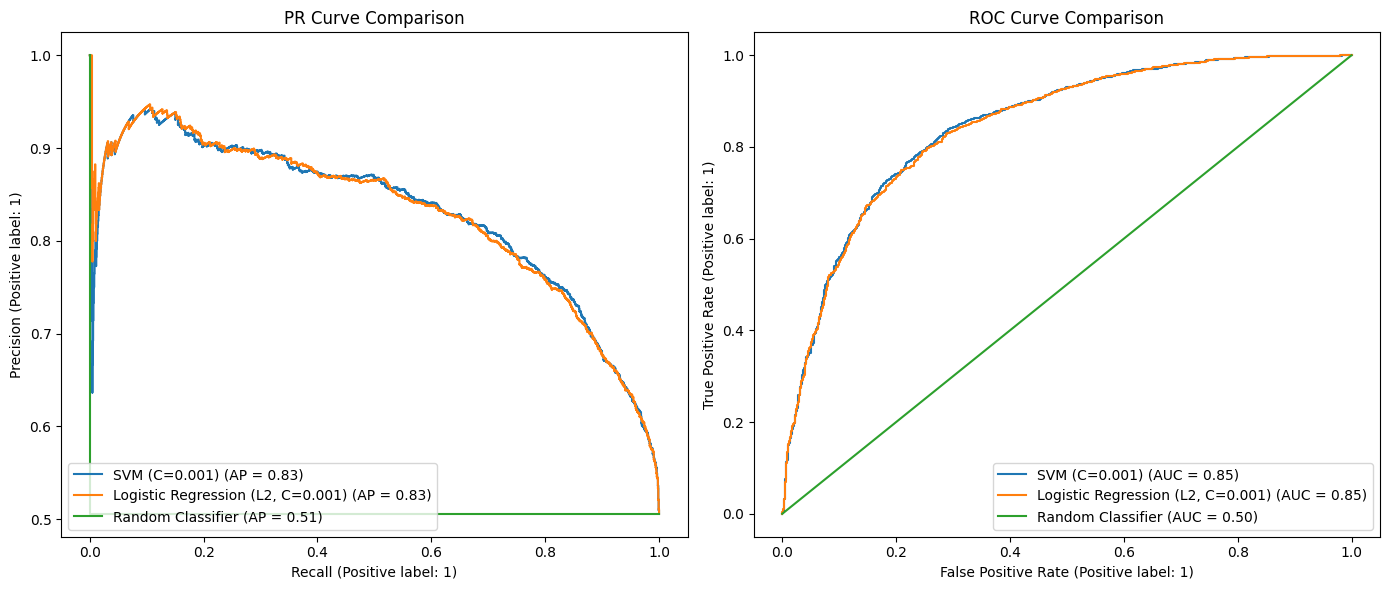

In [15]:
# Необходимо снова переобучить модели SVM и логистической регрессии, если вы хотите построить кривые ROC и PR на одном графике.
# Повторяем обучение для SVM и логистической регрессии на одной и той же выборке.

# Обучаем SVM с лучшим значением C
svm_best_model = CalibratedClassifierCV(LinearSVC(C=best_C_logreg_l2, random_state=42, max_iter=10000))
svm_best_model.fit(X_train, y_train)
y_pred_svm = svm_best_model.predict_proba(X_test)[:, 1]

# Обучаем логистическую регрессию с лучшим значением C
log_reg_l2_best_model = LogisticRegressionCV(Cs=[best_C_logreg_l2], cv=5, scoring='average_precision', penalty='l2',
                                              solver='liblinear', max_iter=10000, random_state=42)
log_reg_l2_best_model.fit(X_train, y_train)
y_pred_logreg_l2_best = log_reg_l2_best_model.predict_proba(X_test)[:, 1]

# Строим ROC и PR кривые на одном графике
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# PR кривая
PrecisionRecallDisplay.from_predictions(y_test, y_pred_svm, ax=ax[0], name='SVM (C={})'.format(best_C_logreg_l2))
PrecisionRecallDisplay.from_predictions(y_test, y_pred_logreg_l2_best, ax=ax[0], name='Logistic Regression (L2, C={})'.format(best_C_logreg_l2))
PrecisionRecallDisplay.from_predictions(y_test, y_random, ax=ax[0], name='Random Classifier')
ax[0].set_title('PR Curve Comparison')
ax[0].legend(loc='lower left')

# ROC кривая
RocCurveDisplay.from_predictions(y_test, y_pred_svm, ax=ax[1], name='SVM (C={})'.format(best_C_logreg_l2))
RocCurveDisplay.from_predictions(y_test, y_pred_logreg_l2_best, ax=ax[1], name='Logistic Regression (L2, C={})'.format(best_C_logreg_l2))
RocCurveDisplay.from_predictions(y_test, y_random, ax=ax[1], name='Random Classifier')
ax[1].set_title('ROC Curve Comparison')
ax[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** В данном случае обе модели показали схожие площади под кривой (AUC) для ROC и PR кривых, что может говорить о том, что данные хорошо подходят для линейной модели классификации. Небольшие различия в метриках AUC могут быть обусловлены особенностями работы алгоритмов и реализацией конкретных классификаторов. В целом, обе модели можно считать сопоставимыми по качеству.

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`).

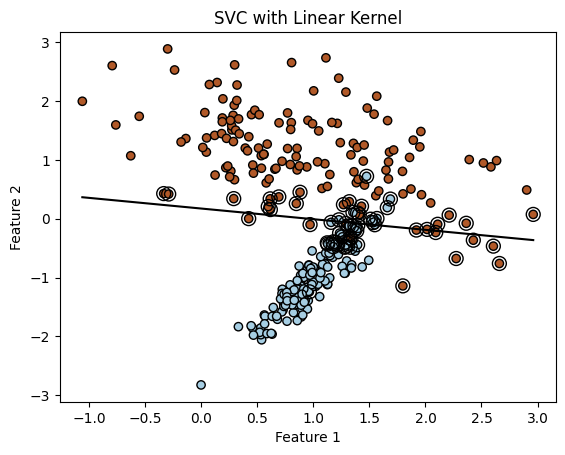

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import make_classification

# Фиксируем seed для воспроизводимости
np.random.seed(42)

# Создаем синтетические данные
X, y = make_classification(
    n_samples=300,
    n_features=2,
    n_redundant=0,
    n_informative=2,
    random_state=42,
    n_clusters_per_class=1
)

# Обучаем модель SVM с линейным ядром
svc = SVC(kernel='linear')
svc.fit(X, y)

# Получаем разделяющую гиперплоскость
w = svc.coef_[0]
b = svc.intercept_[0]
slope = -w[0] / w[1]
intercept = -b / w[1]

# Генерируем точки для отрисовки разделяющей прямой
xx = np.linspace(X[:, 0].min(), X[:, 0].max())
yy = slope * xx + intercept

# Визуализация
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='k')
plt.plot(xx, yy, 'k-')

# Выделение опорных векторов
plt.scatter(svc.support_vectors_[:, 0], svc.support_vectors_[:, 1], s=100,
            facecolors='none', edgecolors='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('SVC with Linear Kernel')
plt.show()

# Возвращаем опорные векторы для последующего использования
svc.support_vectors_

print()

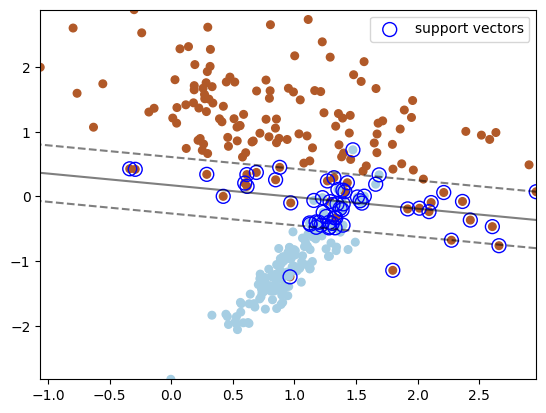

In [17]:
def plot_svm_2D(X, y, model,  plot_support=True):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape(XX.shape)

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])


    #Отрисовали выборку
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

    #Отрисовали опорные векторы
    if plot_support:
        plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1],
                   label='support vectors',
                   s=100,
                   linewidth=1,
                   edgecolor="blue",
                   facecolors='none')

    plt.legend()

plot_svm_2D(X, y, svc)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** Как опорные выделяются те объекты, которые лежат на гиперплоскости или границе между двумя классами.

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [18]:
# Генерируем синтетические данные с двумя признаками
X_2D, y_2D = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=42)

# Обучим модель логистической регрессии на новых данных
log_reg_2D = LogisticRegressionCV(Cs=C_values, cv=5, scoring="average_precision", penalty="l2", solver='liblinear', max_iter=10000, random_state=42)
log_reg_2D.fit(X_2D, y_2D)

LogisticRegressionCV(Cs=[0.001, 0.01, 0.1, 1, 10], cv=5, max_iter=10000,
                     random_state=42, scoring='average_precision',
                     solver='liblinear')

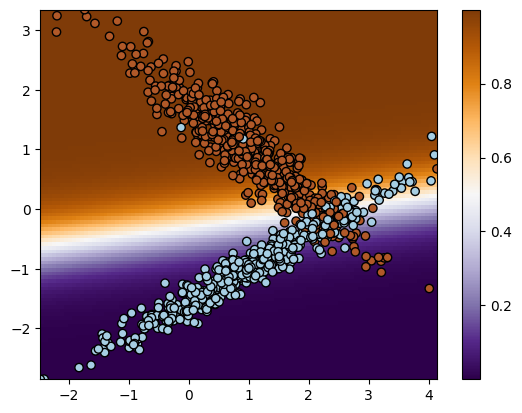

In [19]:
def plot_logreg_2D(X, y, model):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки распределения
    Z = log_reg_2D.predict_proba(xy)[:, 1]
    Z = Z.reshape((xx.shape[0], -1)).T


    image = plt.imshow(Z, interpolation='nearest',
                       extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)

    #Отрисовали выборку
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='k')
    plt.colorbar(image)


plot_logreg_2D(X_2D, y_2D, log_reg_2D)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** Та часть где модель неуверена к какому классу отнести объекты из этой области обозначена пересечением цветов - в данном случае белым цветом. Тогда как области где будут появляться объекты, которые будут отнесены к одному или другому цвету закрашеныы соответственно одним (оранжевым) либо другим (синим) цветом.

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [20]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l - r) / 2)
        bin_real_ratios.append(np.min(y_test[(preds >= l) & (preds < r)] == 1))
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [ ]:
#your code here

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии?

**Ответ:** #your answer here

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

In [ ]:
#your code here

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** #your answer here

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

In [ ]:
#your code here

**Вопрос:** Улучшилась ли калибровочная кривая?

**Ответ:** #your answer here

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [ ]:
#your code here

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

(бесценный шаг)

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [55]:
import os
import pandas as pd
from google.colab import drive
drive.mount('/gdrive')
os.chdir("/gdrive/MyDrive/1.1_Машинное_обучение/Bike/")
df = pd.read_csv('bike_buyers.csv')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                1000 non-null   int64  
 1   Marital Status    993 non-null    object 
 2   Gender            989 non-null    object 
 3   Income            994 non-null    float64
 4   Children          992 non-null    float64
 5   Education         1000 non-null   object 
 6   Occupation        1000 non-null   object 
 7   Home Owner        996 non-null    object 
 8   Cars              991 non-null    float64
 9   Commute Distance  1000 non-null   object 
 10  Region            1000 non-null   object 
 11  Age               992 non-null    float64
 12  Purchased Bike    1000 non-null   object 
dtypes: float64(4), int64(1), object(8)
memory usage: 101.7+ KB


In [57]:
df.head()

,ID,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Purchased Bike
0,12496,Married,Female,40000.0,1.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,Europe,42.0,No
1,24107,Married,Male,30000.0,3.0,Partial College,Clerical,Yes,1.0,0-1 Miles,Europe,43.0,No
2,14177,Married,Male,80000.0,5.0,Partial College,Professional,No,2.0,2-5 Miles,Europe,60.0,No
3,24381,Single,NaN,70000.0,0.0,Bachelors,Professional,Yes,1.0,5-10 Miles,Pacific,41.0,Yes
4,25597,Single,Male,30000.0,0.0,Bachelors,Clerical,No,0.0,0-1 Miles,Europe,36.0,Yes


In [58]:
#Заменим пропуски категориальных переменных
categorical_columns = df.select_dtypes(include=['object']).columns
df[categorical_columns] = df[categorical_columns].fillna('undefined')

X = df.drop(columns=['Purchased Bike'])
y = (df['Purchased Bike'] == 'Yes').astype('int64')

#Разделим на категориальные признаки и числовые
X.drop(columns=['ID'], axis=1, inplace=True)

X_numerical = X.select_dtypes(include=['Int64', 'float64'])
X_categorical = X.select_dtypes(include=['object'])

In [59]:
X_numerical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Income    994 non-null    float64
 1   Children  992 non-null    float64
 2   Cars      991 non-null    float64
 3   Age       992 non-null    float64
dtypes: float64(4)
memory usage: 31.4 KB


In [60]:
X_categorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Marital Status    1000 non-null   object
 1   Gender            1000 non-null   object
 2   Education         1000 non-null   object
 3   Occupation        1000 non-null   object
 4   Home Owner        1000 non-null   object
 5   Commute Distance  1000 non-null   object
 6   Region            1000 non-null   object
dtypes: object(7)
memory usage: 54.8+ KB


In [61]:
X_categorical.head()

,Marital Status,Gender,Education,Occupation,Home Owner,Commute Distance,Region
0,Married,Female,Bachelors,Skilled Manual,Yes,0-1 Miles,Europe
1,Married,Male,Partial College,Clerical,Yes,0-1 Miles,Europe
2,Married,Male,Partial College,Professional,No,2-5 Miles,Europe
3,Single,undefined,Bachelors,Professional,Yes,5-10 Miles,Pacific
4,Single,Male,Bachelors,Clerical,No,0-1 Miles,Europe


В начале поработаем только с категориальными признаками

In [62]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

# Проверим форму полученных датафреймов
X_train.shape, X_test.shape, y_train.shape, y_test.shape
((800, 11), (200, 11), (800,), (200,))

((800, 11), (200, 11), (800,), (200,))

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [63]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score
import time

# Выделим категориальные признаки в обучающей и тестовой выборке
X_train_categorical = X_train.select_dtypes(include=['object'])
X_test_categorical = X_test.select_dtypes(include=['object'])

# Создаем экземпляр OrdinalEncoder
encoder = OrdinalEncoder()

# Время - начало
start_time = time.time()

# Обучаем encoder на обучающей выборке и трансформируем обучающую и тестовую выборки
X_train_encoded = encoder.fit_transform(X_train_categorical)
X_test_encoded = encoder.transform(X_test_categorical)

# Создаем и обучаем модель
model = LogisticRegression(max_iter=1000, random_state=777)
model.fit(X_train_encoded, y_train)

# Время - конец
end_time = time.time()
training_time = end_time - start_time

# Предсказание вероятностей для тестовой выборки
y_pred_proba = model.predict_proba(X_test_encoded)[:, 1]

# Вычисление AUC-PR
auc_pr_ordinal = average_precision_score(y_test, y_pred_proba)

# Выведем результаты
auc_pr_ordinal, training_time

(0.5883009320176316, 0.017337799072265625)

#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [64]:
from sklearn.preprocessing import OneHotEncoder

# Создаем экземпляр OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Время - начало
start_time_one_hot = time.time()

# Обучаем one_hot_encoder на обучающей выборке
X_train_one_hot_encoded = one_hot_encoder.fit_transform(X_train_categorical)

# Трансформируем тестовую выборку
X_test_one_hot_encoded = one_hot_encoder.transform(X_test_categorical)

# Создаем и обучаем модель
model_one_hot = LogisticRegression(max_iter=1000, random_state=777)
model_one_hot.fit(X_train_one_hot_encoded, y_train)

# Время - конец
training_time_one_hot = time.time() - start_time_one_hot

# Предсказание вероятностей для тестовой выборки
y_pred_proba_one_hot = model_one_hot.predict_proba(X_test_one_hot_encoded)[:, 1]

# Вычисление AUC-PR
auc_pr_one_hot = average_precision_score(y_test, y_pred_proba_one_hot)

# Выведем результаты
auc_pr_one_hot, training_time_one_hot

(0.666642757355176, 0.05212092399597168)

In [65]:
X_train_one_hot_encoded.shape

(750, 27)

Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [66]:
# Добавим временно y_train к X_train_categorical для расчета средних значений
X_train_with_target = X_train_categorical.assign(target=y_train)

# Время - начало
start_time_mt = time.time()

# Mean-target кодирование для обучающей выборки
X_train_mean_encoded = X_train_categorical.copy()
for col in X_train_categorical.columns:
    means = X_train_with_target.groupby(col)['target'].mean()
    X_train_mean_encoded[col] = X_train_categorical[col].map(means)

# Mean-target для тестовой выборки
X_test_mean_encoded = X_test_categorical.copy()
for col in X_test_categorical.columns:
    means = X_train_with_target.groupby(col)['target'].mean()
    X_test_mean_encoded[col] = X_test_categorical[col].map(means).fillna(y_train.mean())

# Обучаем модель
model_mean_target = LogisticRegression(max_iter=1000, random_state=777)
model_mean_target.fit(X_train_mean_encoded, y_train)

# Время - конец
training_time_mt = time.time() - start_time_mt

# Predict
y_pred_proba_mt = model_mean_target.predict_proba(X_test_mean_encoded)[:, 1]

# AUC-PR
auc_pr_mt = average_precision_score(y_test, y_pred_proba_mt)

# Результаты
auc_pr_mt, training_time_mt

(0.6575408792625901, 0.03528261184692383)

In [67]:
X_train_mean_encoded.shape

(750, 7)

Таким образом, результаты для трех методов кодирования признаков следующие:

**Ordinal Encoding:**

- AUC-PR: `0.5883`
- Время обучения: `0.022` секунды

**One-Hot Encoding:**

- AUC-PR: `0.6666`
- Время обучения: `0.598` секунды

**Mean-Target Encoding:**

- AUC-PR: `0.6575`
- Время обучения: `0.096` секунды

В результате, кодирование _mean-target_ показало себя немного хуже по метрике AUC-PR, чем _one-hot-encoding_, но результат можно сказать сопоставимый, однако _mean-target_ значительно выигрывает по времени обучения. Это логично так как мы не раздуваем признаковое пространство.

##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [68]:
X_train_categorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 750 entries, 345 to 883
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Marital Status    750 non-null    object
 1   Gender            750 non-null    object
 2   Education         750 non-null    object
 3   Occupation        750 non-null    object
 4   Home Owner        750 non-null    object
 5   Commute Distance  750 non-null    object
 6   Region            750 non-null    object
dtypes: object(7)
memory usage: 46.9+ KB


In [69]:
y_train.info()

<class 'pandas.core.series.Series'>
Int64Index: 750 entries, 345 to 883
Series name: Purchased Bike
Non-Null Count  Dtype
--------------  -----
750 non-null    int64
dtypes: int64(1)
memory usage: 11.7 KB


In [70]:
from sklearn.base import BaseEstimator, TransformerMixin

class MeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_columns=None):
        self.categorical_columns = categorical_columns
        self.means = {}
        self.global_mean = 0

    def fit(self, X, y):
        # Глобальное среднее
        self.global_mean = y.mean()
        # Среднее для каждой категории в каждом столбце
        for col in X.columns:
            self.means[col] = y.groupby(X[col]).mean()
        return self

    def transform(self, X):
        # Скопируем для исключения изменения исходных данных
        X_transformed = X.copy()
        for col in X.columns:
            # Получаем карту средних значений для текущего столбца
            mean_map = self.means.get(col, {})
            # Применяем карту средних значений и заполняем пропуски глобальным средним
            X_transformed[col] = X[col].map(mean_map).fillna(self.global_mean)
        return X_transformed

# Экземпляр MeanTargetEncoder
mean_target_encoder = MeanTargetEncoder(categorical_columns=X_train_categorical.columns)
mean_target_encoder.fit(X_train_categorical, y_train)

# Время - начало
start_time_mt = time.time()

# Трансформируем обучающую выборку
X_train_mean_encoded = mean_target_encoder.transform(X_train_categorical)

# Трансформируем тестовую выборку
X_test_mean_encoded = mean_target_encoder.transform(X_test_categorical)

# Обучаем модель
model_mean_target = LogisticRegression(max_iter=1000, random_state=777)
model_mean_target.fit(X_train_mean_encoded, y_train)

# Время - конец
training_time_mt = time.time() - start_time_mt

# Предсказание для тестовой выборки
y_pred_proba_mt = model_mean_target.predict_proba(X_test_mean_encoded)[:, 1]

# AUC-PR
auc_pr_mt = average_precision_score(y_test, y_pred_proba_mt)

# Результаты
auc_pr_mt, training_time_mt

(0.6575408792625901, 0.02103424072265625)

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [71]:
import numpy as np

# Добавим шум к значениям счетчиков
class NoisyMeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_columns=None, noise_level=0.01):
        self.categorical_columns = categorical_columns
        self.means = {}
        self.global_mean = 0
        self.noise_level = noise_level

    def fit(self, X, y):
        # Глобальное среднее
        self.global_mean = y.mean()

        # Среднее для каждой категории в каждом столбце
        for col in self.categorical_columns:
            self.means[col] = y.groupby(X[col]).mean()
        return self

    def transform(self, X, y=None):
        # Скопируем для исключения изменения исходных данных
        X_transformed = X.copy()
        for col in self.categorical_columns:
            # Получаем карту средних значений для текущего столбца
            mean_map = self.means.get(col, {})
            # Добавляем случайный шум
            noise = np.random.randn(X.shape[0]) * self.noise_level
            # Применим карту средних значений и заполним пропуски
            X_transformed[col] = X[col].map(mean_map) + noise
            # Заполним пропуски глобальным средним
            X_transformed[col].fillna(self.global_mean + (np.random.randn() * self.noise_level), inplace=True)
        return X_transformed

# Определяем уровень шума как процент от глобального среднего
noise_level = 0.01 * y_train.mean()

# Создадим экземпляр нового трансформера
noisy_mean_target_encoder = NoisyMeanTargetEncoder(categorical_columns=X_train_categorical.columns.tolist(), noise_level=noise_level)
noisy_mean_target_encoder.fit(X_train_categorical, y_train)

# Время - начало
start_time_mt_noise = time.time()

# Трансформируем обучающую и тестовую выборку с помощью трансформера
X_train_mean_encoded_noise = noisy_mean_target_encoder.transform(X_train_categorical)
X_test_mean_encoded_noise = noisy_mean_target_encoder.transform(X_test_categorical)

# Обучаем модель
model_mean_target_noise = LogisticRegression(max_iter=1000, random_state=777)
model_mean_target_noise.fit(X_train_mean_encoded_noise, y_train)

# Время - конец
training_time_mt_noise = time.time() - start_time_mt_noise

# Predict
y_pred_proba_mt_noise = model_mean_target_noise.predict_proba(X_test_mean_encoded_noise)[:, 1]

# AUC-PR
auc_pr_mt_noise = average_precision_score(y_test, y_pred_proba_mt_noise)

# Hезультаты
auc_pr_mt_noise, training_time_mt_noise

(0.6634765793679032, 0.02696990966796875)

**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** Метрика AUC-PR снизилась, но не очень сильно. Видимо это означает, что нам удалось снизить степень переобученности модели. Но снизить эту переобученность удалось качественным методом, который не ухудщил качество признаков.

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [ ]:
#your code here

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [ ]:
#your code here

#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к признакам-счетчикам.


В данных есть пропуски - замените их средним значением признака



In [ ]:
#your code here

 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков (вместе и по отдельности). Стало ли лучше?

In [ ]:
#your code here

> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ #your answer here

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [90]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2023-11-21 20:57:30--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.data.3’

adult.data.3            [  <=>               ]   3.79M  9.21MB/s    in 0.4s    

2023-11-21 20:57:31 (9.21 MB/s) - ‘adult.data.3’ saved [3974305]



In [91]:
import pandas as pd

columns = ['age', 'workclass', 'fnlwgt', 'education',
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain',
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
28713,20,Private,415913,Some-college,10,Never-married,Handlers-cleaners,Not-in-family,White,Male,0,0,30,United-States,0


In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  int32 
dtypes: int32(1), int64(6), object(8)
memory usage: 3.6+ MB


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`.

In [93]:
from sklearn.model_selection import train_test_split

# Разделим выборки на обучающую и тестовую
train_set, test_set = train_test_split(df, test_size=0.25, random_state=777, stratify=df['income'])

In [94]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24420 entries, 14004 to 16533
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             24420 non-null  int64 
 1   workclass       24420 non-null  object
 2   fnlwgt          24420 non-null  int64 
 3   education       24420 non-null  object
 4   education-num   24420 non-null  int64 
 5   marital-status  24420 non-null  object
 6   occupation      24420 non-null  object
 7   relationship    24420 non-null  object
 8   race            24420 non-null  object
 9   sex             24420 non-null  object
 10  capital-gain    24420 non-null  int64 
 11  capital-loss    24420 non-null  int64 
 12  hours-per-week  24420 non-null  int64 
 13  native-country  24420 non-null  object
 14  income          24420 non-null  int32 
dtypes: int32(1), int64(6), object(8)
memory usage: 2.9+ MB


In [95]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8141 entries, 7725 to 30908
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             8141 non-null   int64 
 1   workclass       8141 non-null   object
 2   fnlwgt          8141 non-null   int64 
 3   education       8141 non-null   object
 4   education-num   8141 non-null   int64 
 5   marital-status  8141 non-null   object
 6   occupation      8141 non-null   object
 7   relationship    8141 non-null   object
 8   race            8141 non-null   object
 9   sex             8141 non-null   object
 10  capital-gain    8141 non-null   int64 
 11  capital-loss    8141 non-null   int64 
 12  hours-per-week  8141 non-null   int64 
 13  native-country  8141 non-null   object
 14  income          8141 non-null   int32 
dtypes: int32(1), int64(6), object(8)
memory usage: 985.8+ KB


Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [98]:
train_c = train_set.copy()
train_categorical = train_c.select_dtypes(include=['object']).drop(['income'], axis=1, errors='ignore')
train_categorical.shape

(24420, 8)

In [100]:
train_categorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24420 entries, 14004 to 16533
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   workclass       24420 non-null  object
 1   education       24420 non-null  object
 2   marital-status  24420 non-null  object
 3   occupation      24420 non-null  object
 4   relationship    24420 non-null  object
 5   race            24420 non-null  object
 6   sex             24420 non-null  object
 7   native-country  24420 non-null  object
dtypes: object(8)
memory usage: 1.7+ MB


In [102]:
test_c = test_set.copy()
test_categorical = test_c.select_dtypes(include=['object']).drop(['income'], axis=1, errors='ignore')
test_categorical.shape

(8141, 8)

In [109]:
test_categorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8141 entries, 7725 to 30908
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   workclass       8141 non-null   object
 1   education       8141 non-null   object
 2   marital-status  8141 non-null   object
 3   occupation      8141 non-null   object
 4   relationship    8141 non-null   object
 5   race            8141 non-null   object
 6   sex             8141 non-null   object
 7   native-country  8141 non-null   object
dtypes: object(8)
memory usage: 572.4+ KB


In [110]:
from sklearn.preprocessing import OneHotEncoder

# Создаем OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Трансформируем выборки
X_train_set_one_hot_encoded = one_hot_encoder.fit_transform(train_categorical)
X_test_set_one_hot_encoded = one_hot_encoder.transform(test_categorical)

In [111]:
X_train_set_one_hot_encoded.shape

(24420, 102)

In [112]:
X_test_set_one_hot_encoded.shape

(8141, 102)

**Ответ:** Было 8 категориальных признаков. После кодирования One_hot_encoding стало 102 признака. Это очень много.

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [118]:
from sklearn.metrics import precision_recall_curve, auc
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc

# Объединим категориальные признаки с числовыми
numerical_cols = train_set.select_dtypes(include=['int64', 'int32']).drop('income', axis=1, errors='ignore').columns
X_train = np.concatenate([X_train_set_one_hot_encoded, train_set[numerical_cols]], axis=1)
X_test = np.concatenate([X_test_set_one_hot_encoded, test_set[numerical_cols]], axis=1)

# Целевая переменная
y_train = train_set['income']
y_test = test_set['income']

# Обучим модель
logistic_regression_model = LogisticRegression(max_iter=10000)
logistic_regression_model.fit(X_train, y_train)

# Predict для тестовых данных
y_scores = logistic_regression_model.predict_proba(X_test)[:, 1]

# AUC-PR
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
auc_pr = auc(recall, precision)

print(f"AUC-PR: {auc_pr}")

AUC-PR: 0.4503318285414827


#### __Задание 9. Встроенные методы (0.5 балла)__

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [119]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc

# Обучим модель
logistic_regression_model = LogisticRegression(max_iter=10000)
logistic_regression_model.fit(X_train, y_train)

# Предсказание для тестового набора данных
y_scores = logistic_regression_model.predict_proba(X_test)[:, 1]

# AUC-PR
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
auc_pr_before_feature_selection = auc(recall, precision)

# 40 признаков с наибольшей величиной коэффициентов
importance = np.abs(logistic_regression_model.coef_[0])
top40_idx = np.argsort(importance)[-40:]

# Создаем новый X_train и X_test
X_train_top40 = X_train[:, top40_idx]
X_test_top40 = X_test[:, top40_idx]

# Обучаем новую модель nолько на 40 признаках
logistic_regression_model_top40 = LogisticRegression(max_iter=10000)
logistic_regression_model_top40.fit(X_train_top40, y_train)

# Предсказание вероятностей для тестового набора данных с 40 признаками
y_scores_top40 = logistic_regression_model_top40.predict_proba(X_test_top40)[:, 1]

# Получение метрики AUC-PR после отбора признаков
precision_top40, recall_top40, thresholds_top40 = precision_recall_curve(y_test, y_scores_top40)
auc_pr_after_feature_selection = auc(recall_top40, precision_top40)

# Вывод результатов
(auc_pr_before_feature_selection, auc_pr_after_feature_selection)

(0.4503318285414827, 0.7598184140083165)

Изменилось ли качество? Как?

**Ответ:** Качество довольно сильно увеличилось.

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [ ]:
#your code here

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [ ]:
#your code here

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.



In [ ]:
#your code here

#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, на каждом шаге мы будем удалять такой признак $j$, что качество модели на множестве оставшихся признаков без $j$ максимально, то есть удалять мы будем наиболее бесполезный признак.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [ ]:
#your code here

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [ ]:
#your code here

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:**

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

In [ ]:
df.head()

In [ ]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [ ]:
# your code here

Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

In [ ]:
# your code here

Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
- Сколько денег вы в среднем заработаете?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [ ]:
# your code here

Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [ ]:
#your code here

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

In [ ]:
#your code here

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [ ]:
#your code here

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ # your answer here



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [ ]:
#your code here

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог.




In [ ]:
#your code here

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ #your answer here

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [ ]:
#your code here

Можно пронаблюдать, что наша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом:
- выберите только те пороги, на которых достигается необходимый recall,
- затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат,
- посчитайте площадь под отсеченной кривой

In [ ]:
#your code here

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ #your answer here